# Importing the file and initial checks

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
from scipy.stats import f_oneway, ttest_ind, pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import io
from google.colab import files


In [ ]:
uploaded = files.upload() #importing the file in the colab

Saving DS_exercise_price_response.csv to DS_exercise_price_response (1).csv


In [ ]:
#reading the uploaded file as a pandas dataframe into the fullData variable
 
fullData = pd.read_csv(io.BytesIO(uploaded["DS_exercise_price_response.csv"]), sep=';', decimal=',')
print(fullData.head()) #checking that the file was imported correctly

   Unnamed: 0        date  weekday  X_price pricing_channel  traffic   profit  \
0           1  2022-01-01        6   -0.200               A     1630  1490.00   
1           2  2022-01-01        6   -0.100               B     3093  2860.00   
2           3  2022-01-02        7   -0.175               A     2312   786.25   
3           4  2022-01-02        7   -0.200               B      909   490.00   
4           5  2022-01-03        1    0.000               A     2968  3300.00   

   profit_per_order  orders  
0         27.592593      54  
1         31.086957      92  
2         15.416667      51  
3         23.333333      21  
4         42.307692      78  


In [ ]:
fullData = fullData.drop('Unnamed: 0', axis = 1) #remove the first column, that is useless
fullData.describe() #initial description to familiarize with the dataset, and to check if there is maybe something weird

,weekday,X_price,traffic,profit,profit_per_order,orders
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.004000,0.000350,2309.899000,1982.560000,39.690787,51.565000
std,2.005993,0.124189,494.731934,739.756961,9.675142,18.693186
min,1.000000,-0.200000,867.000000,420.000000,14.418605,12.000000
25%,2.000000,-0.100000,2001.000000,1404.687500,32.386884,37.000000
50%,4.000000,0.000000,2311.000000,1921.250000,40.000000,51.000000
75%,6.000000,0.100000,2608.500000,2475.000000,47.685239,64.000000
max,7.000000,0.200000,3956.000000,4820.000000,61.012658,134.000000


In [ ]:
fullData.corr() #initial check of the correlations, again to familiarize

,weekday,X_price,traffic,profit,profit_per_order,orders
weekday,1.000000,0.029327,0.018503,-0.193047,-0.265759,-0.000728
X_price,0.029327,1.000000,0.061497,0.227972,0.892500,-0.370166
traffic,0.018503,0.061497,1.000000,0.605201,0.057336,0.585348
profit,-0.193047,0.227972,0.605201,1.000000,0.326351,0.735971
profit_per_order,-0.265759,0.892500,0.057336,0.326351,1.000000,-0.354749
orders,-0.000728,-0.370166,0.585348,0.735971,-0.354749,1.000000


These are some initial correlations to understand what's going on. We can notice some important stuff. 

We notice a strong correlation between the X_price and the profit_per_order. Yet a low correlation between X_profit and profit. Since our aim is to maximize profit, then this is an important point to adress.

Likewise there is a good correlation between orders and profit, likely because the more the orders the more the profit.

Another point is that there is a positive medium correlation between traffic and number of orders. 

We will adress these points, and more, in the following sections.

#First plots of the dataframe
This (boring) section is to check the histograms and plots of the various columns of the dataframe. This is something I do to visually check for normality (which is an important assumption to have), and to spot if there is anything weird. There are statistical tests to do this too, but in my experience a visual check suffices, plus in this way one can maybe gather information about the distribution if it is not normal. I suggest to collapse this section (and the next ones) when done, so to not clutter the colab notebook.

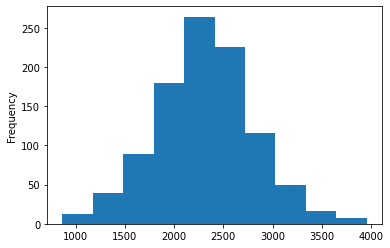

In [ ]:
fullData['traffic'].plot.hist() #histogram of the traffic

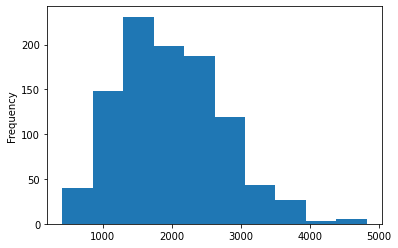

In [ ]:
fullData['profit'].plot.hist() #histogram of the profit

The histogram of the profits looks a bit weird, but for now I'll assume that it is just a truncated gaussian. As for why it is truncated, my guess would be that there is always some minimum of orders, and thus of profits. 

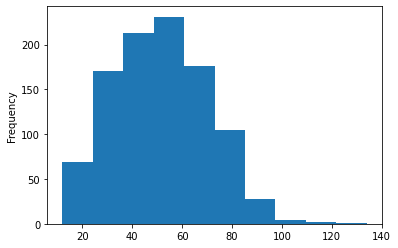

In [ ]:
fullData['orders'].plot.hist() #histogram of the orders

Similar weirdness as before, but it makes sense since profits and orders are correlated.

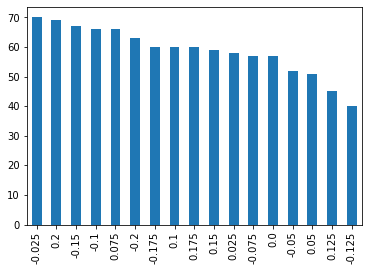

In [ ]:
fullData['X_price'].value_counts().plot(kind='bar') #histogram of the increases in price

Good to know that the increases in price follow a more or less uniform distribution, although one could argue that there wasn't enough sampling for some values (like +/- 0.125). But this is a very minor point in my opinion. 

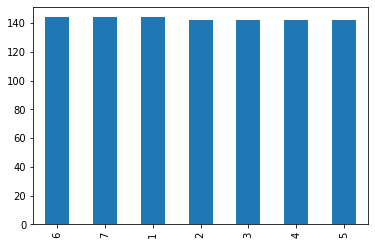

In [ ]:
fullData['weekday'].value_counts().plot(kind='bar') #histogram of the weekday

Similarly for the weekday, it's good that there was good sampling

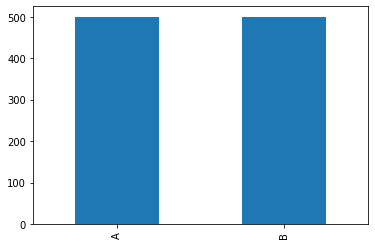

In [ ]:
fullData['pricing_channel'].value_counts().plot(kind='bar') #histogram of the pricing channels

Same as before. 

Given that our independent variable is X_price, but that we also want to segment the customers based on the day of the week and pricing channel, we want to make sure that there was good assigment of X_prices to the various days of the week/channels

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


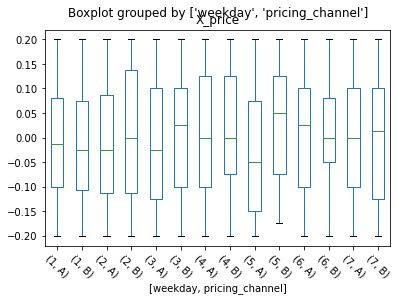

In [ ]:
fullData.boxplot(by =['weekday','pricing_channel'], column =['X_price'], grid = False, rot=-45) #boxplots for the profit per order

Looks good so far! Although one should keep in mind that there was some difference between day 5A and 5B in terms of X_price received (5A received slightly lower prices) 

For now, the boring conclusion is that the data looks good so far. This concludes this section.

# How to deal with the date column
The date data could be useful: maybe there are more people shopping during some months (like december) so let's quickly check if that's true.
Spoiler alert: I found nothing, so this section is skippable in principle, but in my opinion it is still an important part of the process of data inquiry.

In [ ]:
# this is some python magic to add a column with the months, taken from the column 'date'. This is done to check for seasonal effects
fullData['month'] = fullData.apply(lambda row : datetime.datetime.strptime(row['date'],"%Y-%m-%d").strftime("%b"),axis=1)
print(fullData.head())

         date  weekday  X_price pricing_channel  traffic   profit  \
0  2022-01-01        6   -0.200               A     1630  1490.00   
1  2022-01-01        6   -0.100               B     3093  2860.00   
2  2022-01-02        7   -0.175               A     2312   786.25   
3  2022-01-02        7   -0.200               B      909   490.00   
4  2022-01-03        1    0.000               A     2968  3300.00   

   profit_per_order  orders month  
0         27.592593      54   Jan  
1         31.086957      92   Jan  
2         15.416667      51   Jan  
3         23.333333      21   Jan  
4         42.307692      78   Jan  


With this new column we can now print boxlots to check if we find some effects.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


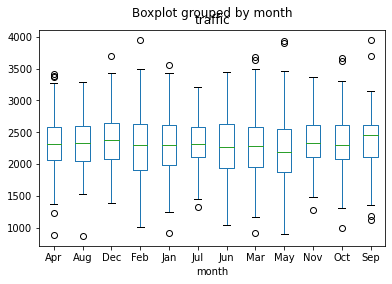

In [ ]:
fullData.boxplot(by ='month', column =['traffic'], grid = False) #boxplots of the traffic by months

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


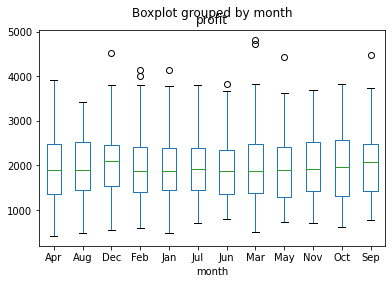

In [ ]:
fullData.boxplot(by ='month', column =['profit'], grid = False) #boxplots of the profit by months

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


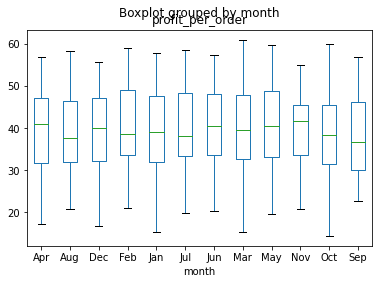

In [ ]:
fullData.boxplot(by ='month', column =['profit_per_order'], grid = False) #boxplots of the profit per order by months

Hmm the boxplots seem to not be able to find any difference!
In fact, even checking with some more rigourous statistics, this appears to be the same:

In [ ]:
#ANOVA between months, to check if there is any difference between the months in terms of the profits
groupedDF = fullData.groupby('month') #we group the data by month

ProfitByMonths = [dataset['profit'] for _, dataset in groupedDF] #ProfitByMonth is a list of the profits for each month

F, p = f_oneway(*ProfitByMonths) #performing an anova test 
print(F, p) #printing the F statistic and the p-value

0.201201982119638 0.9975576411483287


Huge p-value, so we are almost sure there is no difference. One could claim that we should check for the assumptions of the ANOVA test:

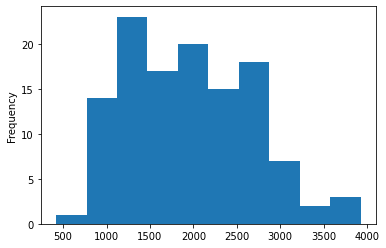

In [ ]:
#if one wants to nitpick, before performing an anova one should check for normality of the groups checked. 
#Likewise one should check if the groups have same variance
#this can be done with the following:
ProfitByMonths[0].plot.hist()
variances = list(map(lambda x : x.var(), ProfitByMonths))

Good! And if one would want to reallynitpick, one could do tests for the specific months, with a t-test:

In [ ]:
cat1 = fullData[fullData['month'] == 'Dec']#data for the month of Dec
cat2 = fullData[fullData['month'] == 'Aug']#data for the month of Aug

ttest_ind(cat1['profit'], cat2['profit']) #t-test for a difference in profits for the data of Dec and Aug

Ttest_indResult(statistic=0.5963851711785991, pvalue=0.5520229391380866)

Still no difference! Let's check a final hypothesis: maybe the months impact the channels used

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


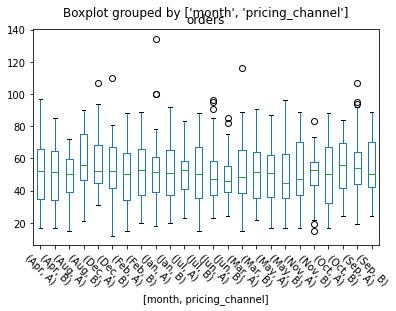

In [ ]:
fullData.boxplot(by =['month','pricing_channel'], column =['orders'], grid = False, rot=-45)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


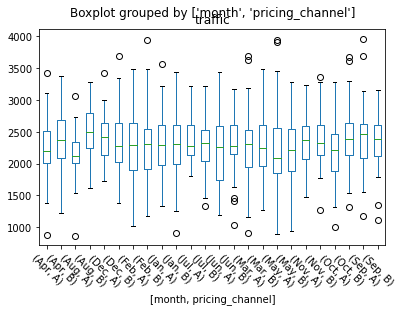

In [ ]:
fullData.boxplot(by =['month','pricing_channel'], column =['traffic'], grid = False, rot=-45)

Okay, in this last case we find that there might be something going on between pricing channel A in August and pricing channel B in August. Yet an anova finds nothing overall. 


In [ ]:
#ANOVA between months and pricing_channel, to check if there is any difference between the months in terms of the profits
groupedDF = fullData.groupby(['month', 'pricing_channel']) #we group the data by month and pricing channel

ProfitByMonths = [dataset['traffic'] for _, dataset in groupedDF] #ProfitByMonth is a list of the profits for each month

F, p = f_oneway(*ProfitByMonths) #performing an anova test 
print(F, p) #printing the F statistic and the p-value

0.9575915070745089 0.5194576680041458


A t-test would find a difference between these categories, but we made so many tests that this is would likely be due to chance. At this point I would maybe ask someone who worked with the dataset if this hypothesis of difference makes sense. For now, we discard the hypothesis.

In [ ]:
AugData = fullData[fullData['month'] == 'Aug'] #data for the month of Aug
cat1 = AugData[AugData['pricing_channel'] == 'A'] #data for the pricing channel A for august
cat2 = AugData[AugData['pricing_channel'] == 'B'] #data for the pricing channel B for august

ttest_ind(cat1['traffic'], cat2['traffic']) #t-test for a difference in traffic 

Ttest_indResult(statistic=-3.440887591200226, pvalue=0.0010614131582783286)

We can also analyse profit like this, and would find nothing. 

We could do more tests, but for me this is enough to probably conclude that we can likely throw out the date column from the next considerations about the dataset. This concludes this section. 

# A first look at the weekday and pricing channels

Our customers might be segmented based on the day of shopping and on the pricing channel. So we should give a look at the boxplots of each of the 14 classes (7 days of a week X 2 channels).


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


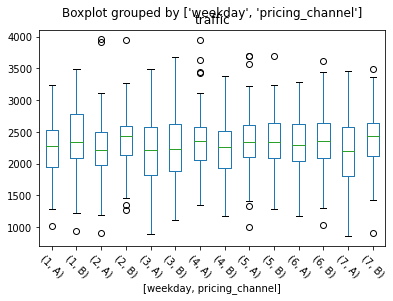

In [ ]:
fullData.boxplot(by =['weekday','pricing_channel'], column =['traffic'], grid = False, rot=-45) #boxplots for the traffic

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


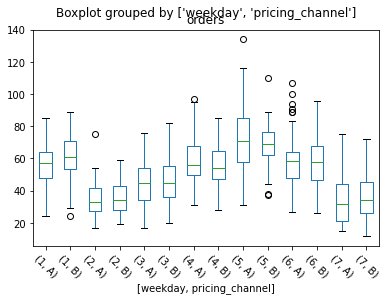

In [ ]:
fullData.boxplot(by =['weekday','pricing_channel'], column =['orders'], grid = False, rot=-45) #boxplots for the orders

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


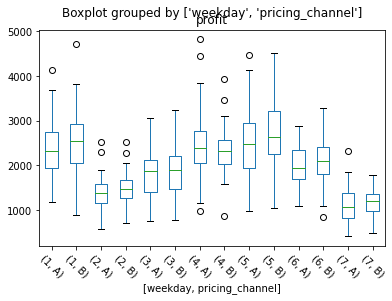

In [ ]:
fullData.boxplot(by =['weekday','pricing_channel'], column =['profit'], grid = False, rot=-45) #boxplots for the profit

One should wonder if there are differences between the channels for each days. This is done with the following test, where no differences were found. (Although some trend for a difference in channels for the first day is noticeable)

In [ ]:
groupedSeg = fullData.groupby(['weekday','pricing_channel']) #grouping the data by weekday and pricing channel
OrdersBySeg = [dataset['orders'] for _, dataset in groupedSeg] #putting in a list all the orders for each of the 14 groups

#performing a t-test between the pricing channels of each day
for i in range(0,7):
  print(ttest_ind(OrdersBySeg[i*2], OrdersBySeg[(i*2)+1]))
   

Ttest_indResult(statistic=-1.8577760871405518, pvalue=0.06527176539341425)
Ttest_indResult(statistic=-0.4739512267577849, pvalue=0.6362730014074127)
Ttest_indResult(statistic=-0.2063302679551287, pvalue=0.8368326964877901)
Ttest_indResult(statistic=1.541559057665784, pvalue=0.12543808386541164)
Ttest_indResult(statistic=1.4257122955522352, pvalue=0.1561772697562986)
Ttest_indResult(statistic=0.010064829244484883, pvalue=0.9919836902107939)
Ttest_indResult(statistic=-1.0401218658549587, pvalue=0.3000510302969262)


Given all of this we can conclude the following:

1.   The traffic is the same along all days of the week (to be sure, this can be checked with an anova, like before).
2.   The orders (and subsequently the profits) seem to depend on the day of the week.
3.   There seem to be no differences between the channels for each day.  
4.   Given these facts it makes sense to further investigate the relationship between the X_price and the other columns by separating by day and channel. 



# Correlations and plots of the orders

In here we will group again by day and channel, and analyze if we can spot some trends regarding the orders

[((1, 'A'), 0.04850211711024917), ((1, 'B'), 0.6104816336621979), ((2, 'A'), 3.58647177049841e-07), ((2, 'B'), 2.7319016944769137e-12), ((3, 'A'), 1.3875746528661206e-06), ((3, 'B'), 9.998960957025557e-06), ((4, 'A'), 1.1127278473406144e-05), ((4, 'B'), 4.103247420193249e-10), ((5, 'A'), 0.003117874166629446), ((5, 'B'), 0.13975348601242416), ((6, 'A'), 3.1072198906952914e-12), ((6, 'B'), 4.8405035194771924e-09), ((7, 'A'), 5.975641499807246e-13), ((7, 'B'), 6.477285201554156e-18)]


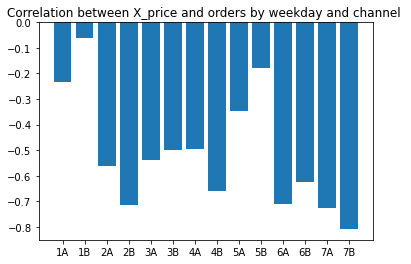

In [ ]:
groupedSeg = fullData.groupby(['weekday','pricing_channel']) #grouping the data by weekday and pricing channel

XpriceBySeg = [(key, dataset['X_price']) for key, dataset in groupedSeg]  #creating a list of tuples ((weekday,channel), X_price of that day and channel)
ordersBySeg = [(key, dataset['orders'])for key, dataset in groupedSeg] #creating a list of tuples ((weekday,channel), orders of that day and channel)

#initializing the lists of correlations, p-values, and a list of the keys indicating the day and channel
corrPriceOrders = []
pValPriceOrders = []
listKey = []

#filling those lists with the correspective data
for num, lis in enumerate(XpriceBySeg):
    listKey.append(str(lis[0][0])+str(lis[0][1])) #data about the keys
    corrPriceOrders.append( pearsonr(ordersBySeg[num][1],lis[1])[0] ) #data about the correlation
    pValPriceOrders.append((lis[0], pearsonr(ordersBySeg[num][1],lis[1])[1] )) #data about the p-values for each day and channel

plt.bar(listKey, corrPriceOrders ) #plot the graph of the correlations
plt.title('Correlation between X_price and orders by weekday and channel ')
print(pValPriceOrders) #print the p-values of each day and channel

Ok we have something interesting: there seems to be some medium/strong correlations for the days 2,3,4,6,7. Technically the p-values of 1A and 5A are also significant, but the correlations are a bit weak, so we won't consider them.

This means 2 main things:


1.   We could try to look at the plots of X_price and orders for the days 2,3,4,6, adn 7, since in these days it seems that the increase in price is affecting the number of orders (and, in consequence, the profit)
2.   We should consider that maybe during days 1 and 5, since there is really low correlation between the orders and the increase in price, then maybe the increase in price doesn't impact the number of sales. So maybe increasing the price the maximum amount possible maximizes the profit. So we will start by analyzing this last hypothesis, focusing on day 1 and 5.



#Checking out day 1 and 5

Our hypothesis is that during day 1 and 5 the orders are not affected by the increase in price. This should mean that the profit correlates with the increase in price during those days. We check this with the following code. 

[((1, 'A'), 8.585355437311653e-06), ((1, 'B'), 2.1592244864834864e-07), ((2, 'A'), 0.4685813211316449), ((2, 'B'), 0.988850178804016), ((3, 'A'), 0.13326534727547976), ((3, 'B'), 0.1453675585655965), ((4, 'A'), 0.0002723885141021058), ((4, 'B'), 0.02959270575930572), ((5, 'A'), 8.535377218035195e-08), ((5, 'B'), 5.563299655262501e-10), ((6, 'A'), 0.04552038839937819), ((6, 'B'), 0.10378099630441302), ((7, 'A'), 0.07420599932284092), ((7, 'B'), 0.33702644916847263)]


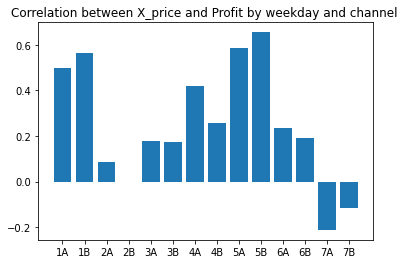

In [ ]:
profitBySeg = [(key, dataset['profit'])for key, dataset in groupedSeg] 

#initializing the lists of correlations, p-values, and a list of the keys indicating the day and channel
corrPriceProfit = []
pValPriceProfit = []
listKey = []

#filling those lists with the correspective data
for num, lis in enumerate(XpriceBySeg):
    listKey.append(str(lis[0][0])+str(lis[0][1])) #data about the keys
    corrPriceProfit.append( pearsonr(profitBySeg[num][1],lis[1])[0] ) #data about the correlation
    pValPriceProfit.append((lis[0], pearsonr(profitBySeg[num][1],lis[1])[1] )) #data about the p-values for each day and channel

plt.bar(listKey, corrPriceProfit ) #plot the graph of the correlations
plt.title('Correlation between X_price and Profit by weekday and channel ')
print(pValPriceProfit) #print the p-values of each day and channel

The peaks for day 1 and 5 is exactly what we expected. It means that there is a medium correlation between the increase in price and the profit for day 1 and 5. So what could determine the orders during those days? So far we haven't looked at the effect of the traffic on the orders. Let's check it.

[((1, 'A'), 7.498125245085066e-35), ((1, 'B'), 7.745140529323385e-40), ((2, 'A'), 1.2123866456745159e-11), ((2, 'B'), 2.0374454114509087e-07), ((3, 'A'), 1.025945524388321e-18), ((3, 'B'), 3.9653800010332285e-18), ((4, 'A'), 4.353405608284312e-18), ((4, 'B'), 2.060445395598253e-18), ((5, 'A'), 4.8550024936712697e-23), ((5, 'B'), 8.055101655074904e-20), ((6, 'A'), 1.1722417003857864e-10), ((6, 'B'), 2.8859515347473916e-12), ((7, 'A'), 7.942599529230914e-09), ((7, 'B'), 1.8982911201935068e-05)]


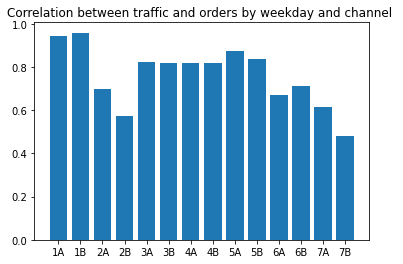

In [ ]:
trafficBySeg = [(key, dataset['traffic'])for key, dataset in groupedSeg] #creating a list of tuples ((weekday,channel), profit of that day and channel)

#initializing the lists of correlations, p-values, and a list of the keys indicating the day and channel
corrTrafficOrders = []
pValTrafficOrders = []
listKey = []

#filling those lists with the correspective data
for num, lis in enumerate(trafficBySeg):
    listKey.append(str(lis[0][0])+str(lis[0][1])) #data about the keys
    corrTrafficOrders.append( pearsonr(ordersBySeg[num][1],lis[1])[0] ) #data about the correlation
    pValTrafficOrders.append((lis[0], pearsonr(ordersBySeg[num][1],lis[1])[1] )) #data about the p-values for each day and channel

plt.bar(listKey, corrTrafficOrders ) #plot the graph of the correlations
plt.title('Correlation between traffic and orders by weekday and channel ')
print(pValTrafficOrders) #print the p-values of each day and channel

We find high correlations between the traffic and the orders for day 1 and 5. So we conclude that in those days it is the traffic that drives the orders, and thus the prices. 

But we also notice that the traffic would explain the number of orders during the other days (with different correlations for day 2,6 and 7). This is a thing to keep in mind while we try to maximize the profits for day 2,3,4,6,7.

#Relation between X_price and orders for day 2,3,4,6,7.

Let's start to look at the price curves for the days in which the increase in price is affecting the orders.

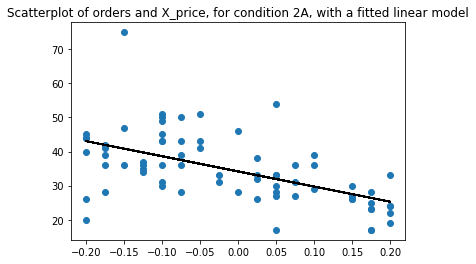

the coeff and intercept for 2A are: -44.47332686711928 34.17022308438409


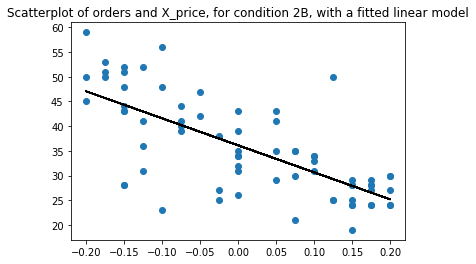

the coeff and intercept for 2B are: -54.724269147136994 36.11846913505678


In [ ]:
#for example, let's look at the plots of 2A and 2B

#first prepare the lists of Xprice and of Orders
listOfXPrice = list(map(lambda x : x[1], XpriceBySeg))
listOrders = list(map(lambda x : x[1], ordersBySeg))
#fit a linear model for the 2A condition
modelA = LinearRegression().fit(np.array(listOfXPrice[2]).reshape(-1, 1), np.array(listOrders[2]))
#fit a linear model for the 2B condition
modelB = LinearRegression().fit(np.array(listOfXPrice[3]).reshape(-1, 1), np.array(listOrders[3]))

#printing the plot of 2A
plt.scatter(listOfXPrice[2], listOrders[2])
plt.plot(listOfXPrice[2], modelA.predict(np.array(listOfXPrice[2]).reshape(-1, 1)),color='k')
plt.title('Scatterplot of orders and X_price, for condition 2A, with a fitted linear model')
plt.show()
print('the coeff and intercept for 2A are:', modelA.coef_[0], modelA.intercept_)

#printing the plot of 2B
plt.scatter(listOfXPrice[3], listOrders[3])
plt.plot(listOfXPrice[3], modelB.predict(np.array(listOfXPrice[3]).reshape(-1, 1)),color='k')
plt.title('Scatterplot of orders and X_price, for condition 2B, with a fitted linear model')
plt.show()
print('the coeff and intercept for 2B are:', modelB.coef_[0], modelB.intercept_)

So we are starting to have some predictive power, by using X_price we can try to predict the number of orders, and in this way we are getting closer to a price elasticity curve. Now we can check if the fitted lines look different for the different days (2,3,4,6,7) and channels.

In [ ]:
#this is a bit ugly, but it is faster than thinking about a weird for loop: it's just a bunch of linear regressions for the various conditions 
model2A = LinearRegression().fit(np.array(listOfXPrice[2]).reshape(-1, 1), np.array(listOrders[2]))
print('the coeff and intercept for 2A are:', model2A.coef_[0], model2A.intercept_, )
model2B = LinearRegression().fit(np.array(listOfXPrice[3]).reshape(-1, 1), np.array(listOrders[3]))
print('the coeff and intercept for 2B are:', model2B.coef_[0], model2B.intercept_)

model3A = LinearRegression().fit(np.array(listOfXPrice[4]).reshape(-1, 1), np.array(listOrders[4]))
print('the coeff and intercept for 3A are:', model3A.coef_[0], model3A.intercept_)
model3B = LinearRegression().fit(np.array(listOfXPrice[5]).reshape(-1, 1), np.array(listOrders[5]))
print('the coeff and intercept for 3B are:', model3B.coef_[0], model3B.intercept_)

model4A = LinearRegression().fit(np.array(listOfXPrice[6]).reshape(-1, 1), np.array(listOrders[6]))
print('the coeff and intercept for 4A are:', model4A.coef_[0], model4A.intercept_)
model4B = LinearRegression().fit(np.array(listOfXPrice[7]).reshape(-1, 1), np.array(listOrders[7]))
print('the coeff and intercept for 4B are:', model4B.coef_[0], model4B.intercept_)

model6A = LinearRegression().fit(np.array(listOfXPrice[10]).reshape(-1, 1), np.array(listOrders[10]))
print('the coeff and intercept for 6A are:', model6A.coef_[0], model6A.intercept_)
model6B = LinearRegression().fit(np.array(listOfXPrice[11]).reshape(-1, 1), np.array(listOrders[11]))
print('the coeff and intercept for 6B are:', model6B.coef_[0], model6B.intercept_)

model7A = LinearRegression().fit(np.array(listOfXPrice[12]).reshape(-1, 1), np.array(listOrders[12]))
print('the coeff and intercept for 7A are:', model7A.coef_[0], model7A.intercept_)
model7B = LinearRegression().fit(np.array(listOfXPrice[13]).reshape(-1, 1), np.array(listOrders[13]))
print('the coeff and intercept for 7B are:', model7B.coef_[0], model7B.intercept_)

the coeff and intercept for 2A are: -44.47332686711928 34.17022308438409
the coeff and intercept for 2B are: -54.724269147136994 36.11846913505678
the coeff and intercept for 3A are: -54.70439924820071 44.65639564200907
the coeff and intercept for 3B are: -53.98354179353851 45.94640933152199
the coeff and intercept for 4A are: -54.06624272166379 59.411239802439525
the coeff and intercept for 4B are: -66.13611760013676 56.26031992479061
the coeff and intercept for 6A are: -96.43690400132506 58.87823288611249
the coeff and intercept for 6B are: -88.77496003556598 59.520615972530955
the coeff and intercept for 7A are: -83.13136521851234 33.74046022947016
the coeff and intercept for 7B are: -85.9450884685784 35.775152532031726


Interesting, we find some different coefficients for the days 6 and 7. This analysis could be done with much better statistics, but for now we should consider that maybe day 6 and 7 could be segmented differently from the rest of the days.

Yet the power of these models is not that great (we could measure it with a r2 score), so let's try now to use what we have learned in the previous section, and try to use also the traffic. We will do this by fitting both X_price and traffic to predict the orders.

In [ ]:
dataDays = fullData[(fullData['weekday']!= 1) & (fullData['weekday']!= 5)] #picking the data for days 2,3,4,6,7
X = np.array([list(dataDays['X_price']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders']) #the variable we are trying to predict, i.e. orders
#creating the linear model, fitting X and y. Then printing the r^2 (how good the model performs), and the coefficents
reg = LinearRegression().fit(X, y) 
print(reg.score(X, y))
print(reg.coef_,  reg.intercept_)

0.5677579076666335
[-6.76196852e+01  1.99810290e-02] 0.478167971744881


Good-ish but not great, let's see if focusing only on day 3 and 4 we get better results (we exclude 2,6,7 because they showed different correlation during the previous data explorations) 

In [ ]:
dataDays = fullData[(fullData['weekday']== 4) | (fullData['weekday']== 3)  ]#picking the data for days 3, 4
X = np.array([list(dataDays['X_price']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders']) #the variable we are trying to predict, i.e. orders
#creating the linear model, fitting X and y. Then printing the r^2 (how good the model performs), and the coefficents
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_,  reg.intercept_)

0.8029057247377402
[-5.32826797e+01  2.18680127e-02] 1.9024622854608708


This is a much better score! Let's check the rest of the days.

In [ ]:
dataDays = fullData[ (fullData['weekday']== 2) |(fullData['weekday']== 7)]  #picking the data for days 2, 7
X = np.array([list(dataDays['X_price']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders']) #the variable we are trying to predict, i.e. orders
#creating the linear model, fitting X and y. Then printing the r^2 (how good the model performs), and the coefficents
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_,  reg.intercept_)

0.9242042223311233
[-7.27214539e+01  1.59938408e-02] -1.9249738550919488


Ok i must admit this result is a bit weird, I expected that days 2 and 7 would go on different segments, because of the differences found in the models that only predicted based on X_price. But this seems to work really well. 

In [ ]:
dataDays = fullData[ (fullData['weekday']== 6) ] #picking the data for day 6
X = np.array([list(dataDays['X_price']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders']) #the variable we are trying to predict, i.e. orders
#creating the linear model, fitting X and y. Then printing the r^2 (how good the model performs), and the coefficents
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_,  reg.intercept_)

0.9311562779164759
[-9.40874177e+01  2.44246967e-02] 1.789806617394568


And our final segment is day 6. Now that we have a good model for understanding how to segment the customer base, we can consider how to maximize profits.

We already discussed that for customers appearing on day 1 and 5 we can likely put the higest price.  Yet one could try to do the same analysis that we did for the previous segments:

In [ ]:
dataDays = fullData[ (fullData['weekday']== 5) | (fullData['weekday']== 1)] #picking the data for days 1, 5
X = np.array([list(dataDays['X_price']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders']) #the variable we are trying to predict, i.e. orders
#creating the linear model, fitting X and y. Then printing the r^2 (how good the model performs), and the coefficents
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_,  reg.intercept_)

0.8005289868996707
[-3.98649109e+01  2.88678749e-02] -2.8161563241093006


This is not bad! Since this data driven approach seems to be working better than our previous approach based on hypothesis testing, we ought to check if we can cluster these 2 days differently. We notice that the coeafficients are really close to days 4,3. 

So we find a clustering that seems a bit better:

In [ ]:
dataDays = fullData[ (fullData['weekday']== 5) ] #picking the data for day 5
X = np.array([list(dataDays['X_price']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders']) #the variable we are trying to predict, i.e. orders
#creating the linear model, fitting X and y. Then printing the r^2 (how good the model performs), and the coefficents
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_,  reg.intercept_)

0.936720566736395
[-6.01595570e+01  3.11193978e-02] -2.3679405051783675


In [ ]:
dataDays = fullData[(fullData['weekday']== 4) | (fullData['weekday']== 3) | (fullData['weekday']== 1) ]#picking the data for days 1,3,4
X = np.array([list(dataDays['X_price']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders']) #the variable we are trying to predict, i.e. orders
#creating the linear model, fitting X and y. Then printing the r^2 (how good the model performs), and the coefficents
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.coef_,  reg.intercept_)

0.8031903650508676
[-4.58269635e+01  2.36587776e-02] -0.2648758994096596


Very interesting, this segmentation seems to be a better explaination. So we have 2 hypothesis, the segments could be:


*   1,3,4
*   5
*   6
*   2,7

or:

*   3,4
*   1,5
*   6
*   2,7

We will decide based on how this model of the orders performs when trying to maximize the profit.


#How to maximize profits based on segmentation



We have some segments, and for each of them we need to ask how to increase the X_profits to maximize the profits. We could solve this statistically (maybe by trying to predict profit by fitting orders and X_price and traffic) or we could look at the economic theory of price elasticity. 

Following this theory, we assume that we have a linear curve between the price and the orders. Then each point represents a particular choice of price and number of orders at that price. To maximize the profit, we only need to look for the biggest rectangle that sits under this curve (since profit = orders * price).

There are a couple of problems though. We don't have the price, just a percentage change in price. Furtermore, we are selling different products.

From these problems I conclude that we need to make some assumptions on the data. I create an extra column in the dataset that wants to represent a procy of the "real" price. I don't know what the "true" price, so I will consider that it is 1 as a baseline. Then this column of represented prices is just 1 added to the X_price  

In [ ]:
fullData['priceRep'] = fullData.apply(lambda row : row['X_price'] + 1 , axis = 1) #the new column is just X_price + 1 (given that X_price are changes in percentage)

This could be a big assumption. But with this column we can see how far our represented profit is from the real profit. The represented profit is the represented price times the orders.

In [ ]:
fullData['profitRep'] = fullData.apply(lambda row : row['priceRep'] * row['orders'], axis = 1) #the column of represented prices is the column we just added * the orders

Now we want to know how much this is different from the real profit:

(0.8999354205048877, 0.0)


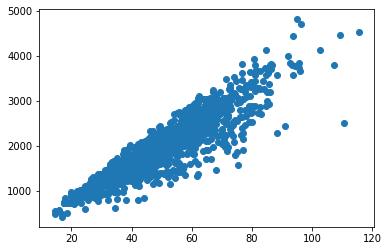

In [ ]:
#we print the correlation and the plot of the real profit and the represented profit
print(pearsonr(fullData['profitRep'], fullData['profit']))
plt.scatter(fullData['profitRep'], fullData['profit'])

Not bad (that is, for small values, but it seems the higher the profit the higher the variance). From this correlation I conclude that I can use the represented price as a proxy for the real prices. 

Now the process for maximizing should be simple. I will have, for each segment, a formula (the linear reagression) that says: 

orders = a * price + b * traffic + c 

I want to maximize the profits, which is price * orders, which gives 
profit = a * price^2+ b * traffic * price + c * price

So, if i remember calculus correctly, I take the first derivative w.r.t price, and I get 2 * a * price + b * traffic  + c = 0, which gets me 

price =  (- b * traffic  - c)/(2 * a) 

Which I can use as a formula to maximize price.


In [ ]:
# we calculate the coefficients for segment 1, 3, 4 with the same process as before

dataDays = fullData[(fullData['weekday']== 4) | (fullData['weekday']== 3) | (fullData['weekday']== 1) ]#picking the data for days 1,3,4
X = np.array([list(dataDays['priceRep']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders'])
reg134 = LinearRegression().fit(X, y)

#assigning the coefficients
a134 = reg134.coef_[0]
b134 = reg134.coef_[1]
c134 = reg134.intercept_


# we calculate the coefficients for segment 5 with the same process as before

dataDays = fullData[(fullData['weekday']== 5) ]#picking the data for days 1,3,4
X = np.array([list(dataDays['priceRep']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders'])
reg5 = LinearRegression().fit(X, y)

#assigning the coefficients
a5 = reg5.coef_[0]
b5 = reg5.coef_[1]
c5 = reg5.intercept_


# we calculate the coefficients for segment 6 with the same process as before

dataDays = fullData[(fullData['weekday']== 6) ]#picking the data for days 1,3,4
X = np.array([list(dataDays['priceRep']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders'])
reg6 = LinearRegression().fit(X, y)

#assigning the coefficients
a6 = reg6.coef_[0]
b6 = reg6.coef_[1]
c6 = reg6.intercept_


# we calculate the coefficients for segment 2, 7 with the same process as before

dataDays = fullData[(fullData['weekday']== 2) | (fullData['weekday']== 7) ]#picking the data for days 1,3,4
X = np.array([list(dataDays['priceRep']), list(dataDays['traffic'])]).transpose() # creating array for the 2 indipendent variables: X_price and traffic
y = np.array(dataDays['orders'])
reg27 = LinearRegression().fit(X, y)

#assigning the coefficients
a27 = reg27.coef_[0]
b27 = reg27.coef_[1]
c27 = reg27.intercept_


# We create the function that takes in input 3 values of the dataframe: weekday, traffic
# and returns the maximized price = (- b * traffic - c)/(2 * a)

def MaxPrice(weekday, traffic):

    if weekday == 1 or weekday == 3 or weekday == 4:
      return (- b134 * traffic - c134)/(2 * a134)
    elif weekday == 5:
      return (- b5 * traffic - c5)/(2 * a5)
    elif weekday == 6:
      return (- b6 * traffic - c6)/(2 * a6)
    else:
      return (- b27 * traffic - c27)/(2 * a27)


#then we apply this function to a new column of predicted max prices:

fullData['maxPrice'] = fullData.apply(lambda row : MaxPrice(row['weekday'],row['traffic']) , axis=1)

# then we create a column of the expected orders following orders = a * price + b * traffic + c 

def ExpOrders(weekday, traffic, price):

    if weekday == 1 or weekday == 3 or weekday == 4:
      return a134 * price + b134 * traffic + c134
    elif weekday == 5:
      return a5 * price + b5 * traffic + c5 
    elif weekday == 6:
      return a6 * price + b6 * traffic + c6 
    else:
      return a27 * price + b27 * traffic + c27 

fullData['expOrders'] = fullData.apply(lambda row : ExpOrders(row['weekday'],row['traffic'],row['maxPrice']) , axis=1)

#then we create a new column of expected profit:
fullData['expProfit'] = fullData.apply(lambda row : row['maxPrice'] * row['expOrders'], axis = 1) 


But are these expected profits better?

In [ ]:
# we create a new column that calculates the percentage increase from the expected profits to the represented profits 
fullData['difference'] = fullData.apply(lambda row : (row['expProfit'] - row['profitRep'])/row['profitRep'], axis = 1) 

print('the percentage increase in profits for segment 134:',fullData[(fullData['weekday']== 1) | (fullData['weekday']== 3) | (fullData['weekday']== 4)]['difference'].describe())
print('the percentage increase in profits for segment 27:',fullData[(fullData['weekday']== 2) | (fullData['weekday']== 7) ]['difference'].describe())
print('the percentage increase in profits for segment 5:',fullData[(fullData['weekday']== 5) ]['difference'].describe())
print('the percentage increase in profits for segment 6:',fullData[(fullData['weekday']== 6) ]['difference'].describe())
print('the percentage increase in profits overall',fullData['difference'].describe())


the percentage increase in profits for segment 134: count    428.000000
mean       0.050489
std        0.138962
min       -0.221904
25%       -0.054208
50%        0.011052
75%        0.167031
max        0.424241
Name: difference, dtype: float64
the percentage increase in profits for segment 27: count    286.000000
mean       0.236876
std        0.252377
min       -0.163370
25%        0.055917
50%        0.180575
75%        0.331338
max        1.188589
Name: difference, dtype: float64
the percentage increase in profits for segment 5: count    142.000000
mean       0.028922
std        0.060703
min       -0.099488
25%       -0.016891
50%        0.028115
75%        0.062410
max        0.202199
Name: difference, dtype: float64
the percentage increase in profits for segment 6: count    144.000000
mean       0.109657
std        0.127753
min       -0.138019
25%        0.013375
50%        0.107282
75%        0.174946
max        0.536765
Name: difference, dtype: float64
the percentage increase i

From this we can conclude that with the proposed increment in price we can achieve overall a 10% increase in profits. This depends on the segment though. For days 2 and 7, this increase reaches 20%! For other days though the story looks different, e.g. for day 5 the increase is only 3%. In fact, if we separate day 1 from day 3 and 4 we get:

In [ ]:
print('the percentage increase in profits for segment 34:',fullData[(fullData['weekday']== 3) | (fullData['weekday']== 4)]['difference'].describe())
print('the percentage increase in profits for segment 1:',fullData[(fullData['weekday']== 1) ]['difference'].describe())


the percentage increase in profits for segment 34: count    284.000000
mean       0.091896
std        0.143032
min       -0.144912
25%       -0.039708
50%        0.062541
75%        0.211015
max        0.424241
Name: difference, dtype: float64
the percentage increase in profits for segment 1: count    144.000000
mean      -0.031176
std        0.083982
min       -0.221904
25%       -0.095104
50%       -0.032928
75%        0.021509
max        0.230648
Name: difference, dtype: float64


It seems that day 3 and 4 reaches a 9% increase (and we haven't even recalculated the coefficients)....while day 1 is actually underperforming. Given this evidence I conclude that probably I could have segmented the days 1 and 5 togather, and should have considered them as days where the price is quite inelastic.

One could repeat this analysis with the other segmentation, but this is easy to do so I'll skip it for now, as this was more an exercise in thinking and interpreting a dataset.

#Stuff that I would have done differently

If I could do this again I would probably split the set into a training and testing set, and then use those to score the linear models and the expected price. Another minor thing that I noticed is that I didn't look at the p-values of the coefficients of the multiple linear reagression. That might have been useful for segmentation purposes.

I found the segments "by hand", by looking at the various differences in the graphs presented above. This is a bit ugly and probably there exist clustering methods that could achieve this automatically. Maybe one could run just a single linear model with also the weekday as a categorical variable. Another option is to consider all the possible combinations made of 4 out of 14 segmentations, this should be the stirling numbers of possible groups of segmentations, and should be around 10 million (if my combinatorics is correct, which often isn't!). Then one could run a linear model on all of them and get the best ones. This could take much more compute time but it should be doable in principle.

The last analysis done on the represented profits is a bit imprecise, and maybe it is assuming too much. There could be an effect of the day on the correlation between the represented profit and the profit (maybe different shares of products are bought on different days). Also there could be effects due to the differen products having different elasticity. So there could be better ways by maybe transforming the orders in percentage increase in orders, or maybe by using the profits by order column.

When creating the represented profit, I could have done something more complex, like representing it as a sum of A + B, where A and B are the prices of two products. Then by varying the initial prices A and B I could have tried to find the prices such that the correlation between the profit and the represented profit was highest. Yet the shares of A and B are also unknown, so this problem is really hard without some further assumptions about the distribution of the prices or the shares.

